# Scenario 3: visualization of ICON LAM on the regular grid 
This notebook allows the interactive visualization of a subset of the fields saved by ICON at the surface and on the regular latitude/longitude grid.

The plots are saved as "png" files.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cfgrib
import colorcet as cc
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

from matplotlib.colors import ListedColormap

In [2]:
# CONSTANTS AND PARAMETERS
# -------------------------
domain = 'R19B07'
start_date = '2024101906'

# Forecasts path
bacy_dir = '../scenario_3/bacy'
data_dir = f'{bacy_dir}/lam/bacy_more/data/{start_date}0000'
if not os.path.isdir(data_dir):
    print('ERROR: Forecast directory does not exist.')

In [3]:
# Finding all files
fname_template = f'fc_{domain:s}_ll.{start_date:s}*0'
flist = sorted(glob.glob(os.path.join(data_dir, fname_template)))
if len(flist):
    print(f'{len(flist):d} files have been found: {os.path.basename(flist[0])} to {os.path.basename(flist[-1])}.')
else:
    print(f'ERROR: No valid files have been found in {data_dir}. We were looking for: {fname_template}.')

2 files have been found: fc_R19B07_ll.20241019060000_00000000 to fc_R19B07_ll.20241019060000_00010000.


In [5]:
%%time
data_lam = xr.open_mfdataset(flist, engine='cfgrib', data_vars='minimal', filter_by_keys={'typeOfLevel': 'surface'},
                             combine='nested', concat_dim='valid_time', decode_timedelta=False)
data_lam

CPU times: user 157 ms, sys: 6.81 ms, total: 163 ms
Wall time: 164 ms


<xarray.Dataset> Size: 29MB
Dimensions:     (valid_time: 2, latitude: 379, longitude: 800)
Coordinates:
    time        datetime64[ns] 8B 2024-10-19T06:00:00
    step        (valid_time) float64 16B 0.0 1.0
    surface     float64 8B 0.0
  * latitude    (latitude) float64 3kB 42.5 42.52 42.54 ... 50.02 50.04 50.06
  * longitude   (longitude) float64 6kB 0.64 0.66 0.68 0.7 ... 16.58 16.6 16.62
  * valid_time  (valid_time) datetime64[ns] 16B 2024-10-19T06:00:00 2024-10-1...
Data variables:
    CLCT        (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    lsrr        (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    lsfwe       (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    tgrp        (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    lsp         (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    crr         (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    csfwe       (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    cp          (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    T_G         (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    sde         (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
    sp          (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 379, 800), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach
    history:                 2025-03-31T12:32 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
# In the regular grid we can compute the latitude and longitude from the forecast output
lat_lam = data_lam.latitude.compute()
lon_lam = data_lam.longitude.compute()

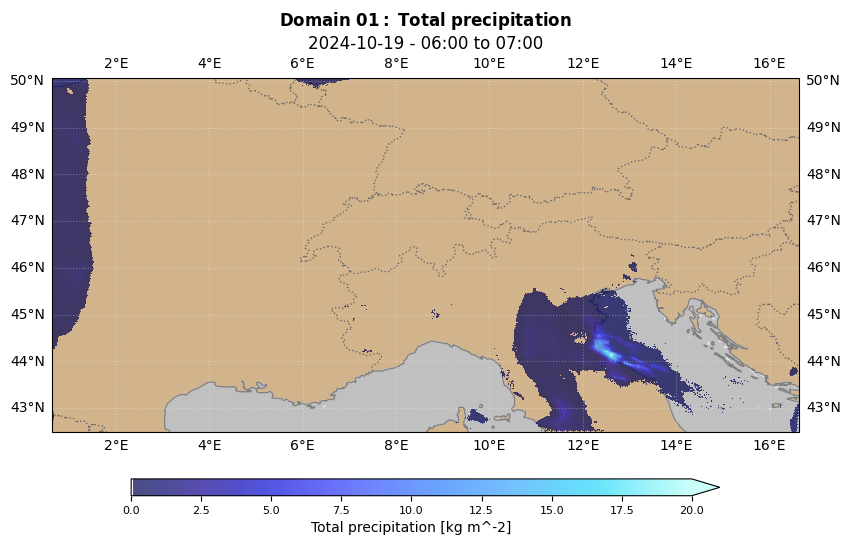

In [8]:
# Plotting with matplotlib
x, y = np.meshgrid(lon_lam, lat_lam)
# We just show the precipitation between the time steps 0 and 1
var = (data_lam['tp'].isel(valid_time=1) - data_lam['tp'].isel(valid_time=0)).compute()

cmap = cc.cm.kbc

new_cmap = cmap(np.linspace(0, 1, 256))
new_cmap[1:, -1] = 0.7
new_cmap[0, -1] = 0  # Set the alpha (transparency) of the first color to 0 (fully transparent)
new_cmap = ListedColormap(new_cmap)

projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(9.5, 6),
                       subplot_kw=dict(projection=projection))

ax.add_feature(cfeature.LAND, edgecolor='w', zorder=0, facecolor='tan')
ax.add_feature(cfeature.OCEAN, edgecolor='none', zorder=0, facecolor='silver')
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=1, edgecolor='dimgray')
ax.add_feature(cfeature.COASTLINE, zorder=1, edgecolor='gray')

mpb = ax.pcolormesh(x, y, var, cmap=new_cmap, transform=projection, vmin=0, vmax=20)
cbar = plt.colorbar(mappable=mpb, orientation='horizontal', shrink=0.7, aspect=35,
                    pad=0.10, label='Total precipitation [kg m^-2]', extend='max')
cbar.ax.tick_params(labelsize=8)  # Reduce tick label size if needed

ax.gridlines(draw_labels=True, ls=':', color='w', alpha=0.3)

d_str = str(np.array(data_lam['valid_time'].isel(valid_time=0).compute())).split('T')[0]
t_str_ini = str(np.array(data_lam['valid_time'].isel(valid_time=0).compute())).split('T')[1].split('.')[0][:-3]
t_str_end = str(np.array(data_lam['valid_time'].isel(valid_time=1).compute())).split('T')[1].split('.')[0][:-3]
ax.set_title(r'$\bf{Domain~01:~Total~precipitation}$' + f'\n{d_str} - {t_str_ini} to {t_str_end}')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to keep title inside
if False:
    # Set to "True" to save the figure
    plt.savefig('tp_lam.png', dpi=300)